# Method 5 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

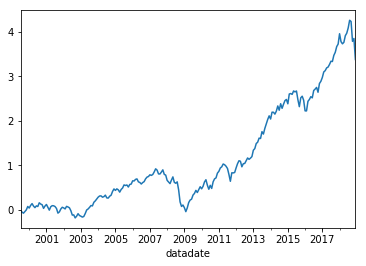

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.076178
2000-12-31    0.009174
2001-12-31   -0.025914
2002-12-31   -0.175033
2003-12-31    0.423758
2004-12-31    0.182703
2005-12-31    0.074264
2006-12-31    0.107691
2007-12-31    0.017970
2008-12-31   -0.377228
2009-12-31    0.370615
2010-12-31    0.200668
2011-12-31    0.007897
2012-12-31    0.193945
2013-12-31    0.416635
2014-12-31    0.118276
2015-12-31   -0.004974
2016-12-31    0.122846
2017-12-31    0.214794
2018-12-31   -0.073217
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2202.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.92e-181
Time:                        04:19:29   Log-Likelihood:                 832.27
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.600      0.000       0.001       0.003
mktrf          0.9554      0.013     73.398      0.000       0.930       0.981
me             0.2228      0.015     14.718      0.000       0.193       0.253
ia             0.1035      0.023      4.498      0.000       0.058       0.149
roe            0.0545      0.020      2.769      0.006       0.016       0.093
==============================================================================
Omnibus:                       11.632   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.923
Skew:                          -0.019   Prob(JB):                     1.42e-06
Kurtosis:                       4.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1231.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.68e-153
Time:                        04:19:29   Log-Likelihood:                 832.27
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.284      0.000       0.001       0.003
mktrf          0.9554      0.018     54.240      0.000       0.921       0.990
me             0.2228      0.034      6.522      0.000       0.156       0.290
ia             0.1035      0.047      2.195      0.028       0.011       0.196
roe            0.0545      0.022      2.532      0.011       0.012       0.097
==============================================================================
Omnibus:                       11.632   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.923
Skew:                          -0.019   Prob(JB):                     1.42e-06
Kurtosis:                       4.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1628.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.22e-167
Time:                        04:19:29   Log-Likelihood:                 832.27
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.586      0.000       0.001       0.003
mktrf          0.9554      0.016     59.278      0.000       0.924       0.987
me             0.2228      0.033      6.856      0.000       0.159       0.287
ia             0.1035      0.054      1.919      0.055      -0.002       0.209
roe            0.0545      0.023      2.394      0.017       0.010       0.099
==============================================================================
Omnibus:                       11.632   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.923
Skew:                          -0.019   Prob(JB):                     1.42e-06
Kurtosis:                       4.661   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1659.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.51e-177
Time:                        04:19:29   Log-Likelihood:                 825.95
No. Observations:                 234   AIC:                            -1640.
Df Residuals:                     228   BIC:                            -1619.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.655      0.000       0.001       0.003
mktrf          0.9666      0.013     71.985      0.000       0.940       0.993
smb            0.2584      0.018     14.586      0.000       0.224       0.293
hml            0.0071      0.021      0.340      0.734      -0.034       0.048
rmw            0.0965      0.024      4.083      0.000       0.050       0.143
cma            0.0775      0.030      2.581      0.010       0.018       0.137
==============================================================================
Omnibus:                       21.490   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.642
Skew:                          -0.010   Prob(JB):                     1.53e-19
Kurtosis:                       5.981   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     889.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.45e-147
Time:                        04:19:29   Log-Likelihood:                 825.95
No. Observations:                 234   AIC:                            -1640.
Df Residuals:                     228   BIC:                            -1619.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.396      0.001       0.001       0.003
mktrf          0.9666      0.021     45.720      0.000       0.925       1.008
smb            0.2584      0.026      9.771      0.000       0.207       0.310
hml            0.0071      0.049      0.145      0.884      -0.089       0.103
rmw            0.0965      0.026      3.775      0.000       0.046       0.147
cma            0.0775      0.048      1.602      0.109      -0.017       0.172
==============================================================================
Omnibus:                       21.490   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.642
Skew:                          -0.010   Prob(JB):                     1.53e-19
Kurtosis:                       5.981   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1233.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.84e-163
Time:                        04:19:29   Log-Likelihood:                 825.95
No. Observations:                 234   AIC:                            -1640.
Df Residuals:                     228   BIC:                            -1619.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.455      0.001       0.001       0.003
mktrf          0.9666      0.020     47.302      0.000       0.927       1.007
smb            0.2584      0.026      9.886      0.000       0.207       0.310
hml            0.0071      0.055      0.130      0.897      -0.100       0.114
rmw            0.0965      0.027      3.517      0.000       0.043       0.150
cma            0.0775      0.046      1.691      0.091      -0.012       0.167
==============================================================================
Omnibus:                       21.490   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.642
Skew:                          -0.010   Prob(JB):                     1.53e-19
Kurtosis:                       5.981   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1738.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.13e-170
Time:                        04:19:29   Log-Likelihood:                 805.38
No. Observations:                 234   AIC:                            -1601.
Df Residuals:                     229   BIC:                            -1583.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.762      0.000       0.001       0.004
mktrf          0.9413      0.013     70.014      0.000       0.915       0.968
smb            0.2047      0.017     12.197      0.000       0.172       0.238
hml            0.1178      0.017      7.064      0.000       0.085       0.151
umd            0.0145      0.011      1.329      0.185      -0.007       0.036
==============================================================================
Omnibus:                       24.294   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.844
Skew:                           0.090   Prob(JB):                     1.41e-24
Kurtosis:                       6.352   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1114.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.23e-149
Time:                        04:19:29   Log-Likelihood:                 805.38
No. Observations:                 234   AIC:                            -1601.
Df Residuals:                     229   BIC:                            -1583.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.010      0.000       0.001       0.004
mktrf          0.9413      0.020     47.619      0.000       0.903       0.980
smb            0.2047      0.033      6.191      0.000       0.140       0.269
hml            0.1178      0.055      2.154      0.031       0.011       0.225
umd            0.0145      0.018      0.804      0.422      -0.021       0.050
==============================================================================
Omnibus:                       24.294   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.844
Skew:                           0.090   Prob(JB):                     1.41e-24
Kurtosis:                       6.352   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1406.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.87e-160
Time:                        04:19:29   Log-Likelihood:                 805.38
No. Observations:                 234   AIC:                            -1601.
Df Residuals:                     229   BIC:                            -1583.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.130      0.000       0.001       0.004
mktrf          0.9413      0.018     52.025      0.000       0.906       0.977
smb            0.2047      0.035      5.869      0.000       0.136       0.273
hml            0.1178      0.064      1.843      0.065      -0.007       0.243
umd            0.0145      0.014      1.034      0.301      -0.013       0.042
==============================================================================
Omnibus:                       24.294   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.844
Skew:                           0.090   Prob(JB):                     1.41e-24
Kurtosis:                       6.352   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     969.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-87
Time:                        04:19:29   Log-Likelihood:                 408.53
No. Observations:                 120   AIC:                            -807.1
Df Residuals:                     115   BIC:                            -793.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.021      0.003       0.001       0.004
mktrf          0.9653      0.021     45.602      0.000       0.923       1.007
me             0.2120      0.021     10.139      0.000       0.171       0.253
ia             0.1557      0.033      4.755      0.000       0.091       0.221
roe            0.0596      0.029      2.055      0.042       0.002       0.117
==============================================================================
Omnibus:                        4.848   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                6.762
Skew:                          -0.019   Prob(JB):                       0.0340
Kurtosis:                       4.162   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     638.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.66e-77
Time:                        04:19:29   Log-Likelihood:                 408.53
No. Observations:                 120   AIC:                            -807.1
Df Residuals:                     115   BIC:                            -793.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.702      0.007       0.001       0.004
mktrf          0.9653      0.027     35.789      0.000       0.912       1.018
me             0.2120      0.036      5.839      0.000       0.141       0.283
ia             0.1557      0.047      3.280      0.001       0.063       0.249
roe            0.0596      0.023      2.624      0.009       0.015       0.104
==============================================================================
Omnibus:                        4.848   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                6.762
Skew:                          -0.019   Prob(JB):                       0.0340
Kurtosis:                       4.162   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1149.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-91
Time:                        04:19:29   Log-Likelihood:                 408.53
No. Observations:                 120   AIC:                            -807.1
Df Residuals:                     115   BIC:                            -793.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.871      0.004       0.001       0.004
mktrf          0.9653      0.022     44.358      0.000       0.923       1.008
me             0.2120      0.036      5.961      0.000       0.142       0.282
ia             0.1557      0.049      3.170      0.002       0.059       0.252
roe            0.0596      0.021      2.889      0.004       0.019       0.100
==============================================================================
Omnibus:                        4.848   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                6.762
Skew:                          -0.019   Prob(JB):                       0.0340
Kurtosis:                       4.162   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     700.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.73e-84
Time:                        04:19:29   Log-Likelihood:                 403.10
No. Observations:                 120   AIC:                            -794.2
Df Residuals:                     114   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.732      0.007       0.001       0.004
mktrf          1.0007      0.023     42.663      0.000       0.954       1.047
smb            0.2661      0.027     10.016      0.000       0.213       0.319
hml            0.0005      0.033      0.016      0.987      -0.064       0.065
rmw            0.1268      0.038      3.303      0.001       0.051       0.203
cma            0.1339      0.042      3.183      0.002       0.051       0.217
==============================================================================
Omnibus:                       11.945   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.707
Skew:                          -0.002   Prob(JB):                     2.91e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     574.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.42e-79
Time:                        04:19:29   Log-Likelihood:                 403.10
No. Observations:                 120   AIC:                            -794.2
Df Residuals:                     114   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.570      0.010       0.001       0.004
mktrf          1.0007      0.039     25.822      0.000       0.925       1.077
smb            0.2661      0.038      7.084      0.000       0.192       0.340
hml            0.0005      0.083      0.006      0.995      -0.162       0.163
rmw            0.1268      0.056      2.270      0.023       0.017       0.236
cma            0.1339      0.065      2.065      0.039       0.007       0.261
==============================================================================
Omnibus:                       11.945   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.707
Skew:                          -0.002   Prob(JB):                     2.91e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1102.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.00e-94
Time:                        04:19:29   Log-Likelihood:                 403.10
No. Observations:                 120   AIC:                            -794.2
Df Residuals:                     114   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.904      0.004       0.001       0.004
mktrf          1.0007      0.037     27.274      0.000       0.929       1.073
smb            0.2661      0.037      7.216      0.000       0.194       0.338
hml            0.0005      0.093      0.006      0.995      -0.182       0.184
rmw            0.1268      0.060      2.117      0.034       0.009       0.244
cma            0.1339      0.065      2.058      0.040       0.006       0.261
==============================================================================
Omnibus:                       11.945   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.707
Skew:                          -0.002   Prob(JB):                     2.91e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     706.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.19e-80
Time:                        04:19:29   Log-Likelihood:                 390.23
No. Observations:                 120   AIC:                            -770.5
Df Residuals:                     115   BIC:                            -756.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.789      0.000       0.002       0.005
mktrf          0.9447      0.022     43.491      0.000       0.902       0.988
smb            0.2048      0.025      8.282      0.000       0.156       0.254
hml            0.1580      0.025      6.377      0.000       0.109       0.207
umd            0.0126      0.015      0.823      0.412      -0.018       0.043
==============================================================================
Omnibus:                       14.862   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               55.043
Skew:                           0.017   Prob(JB):                     1.12e-12
Kurtosis:                       6.318   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     775.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.73e-82
Time:                        04:19:29   Log-Likelihood:                 390.23
No. Observations:                 120   AIC:                            -770.5
Df Residuals:                     115   BIC:                            -756.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.628      0.000       0.002       0.005
mktrf          0.9447      0.032     29.724      0.000       0.882       1.007
smb            0.2048      0.038      5.360      0.000       0.130       0.280
hml            0.1580      0.068      2.338      0.019       0.026       0.290
umd            0.0126      0.021      0.601      0.548      -0.028       0.054
==============================================================================
Omnibus:                       14.862   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               55.043
Skew:                           0.017   Prob(JB):                     1.12e-12
Kurtosis:                       6.318   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1320.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.53e-95
Time:                        04:19:29   Log-Likelihood:                 390.23
No. Observations:                 120   AIC:                            -770.5
Df Residuals:                     115   BIC:                            -756.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.050      0.000       0.002       0.005
mktrf          0.9447      0.026     36.326      0.000       0.894       0.996
smb            0.2048      0.041      4.940      0.000       0.124       0.286
hml            0.1580      0.075      2.098      0.036       0.010       0.306
umd            0.0126      0.017      0.737      0.461      -0.021       0.046
==============================================================================
Omnibus:                       14.862   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               55.043
Skew:                           0.017   Prob(JB):                     1.12e-12
Kurtosis:                       6.318   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1947.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.31e-100
Time:                        04:19:29   Log-Likelihood:                 454.58
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.707      0.000       0.001       0.003
mktrf          0.9475      0.013     70.225      0.000       0.921       0.974
me             0.2495      0.021     11.976      0.000       0.208       0.291
ia            -0.0597      0.029     -2.067      0.041      -0.117      -0.002
roe           -0.0119      0.025     -0.470      0.639      -0.062       0.038
==============================================================================
Omnibus:                        0.075   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.135
Skew:                          -0.059   Prob(JB):                        0.935
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2285.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.24e-104
Time:                        04:19:29   Log-Likelihood:                 454.58
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.161      0.000       0.001       0.003
mktrf          0.9475      0.012     79.855      0.000       0.924       0.971
me             0.2495      0.025     10.058      0.000       0.201       0.298
ia            -0.0597      0.031     -1.908      0.056      -0.121       0.002
roe           -0.0119      0.026     -0.455      0.649      -0.063       0.039
==============================================================================
Omnibus:                        0.075   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.135
Skew:                          -0.059   Prob(JB):                        0.935
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2486.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.50e-106
Time:                        04:19:29   Log-Likelihood:                 454.58
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.652      0.000       0.001       0.003
mktrf          0.9475      0.011     84.037      0.000       0.925       0.970
me             0.2495      0.027      9.093      0.000       0.196       0.303
ia            -0.0597      0.035     -1.690      0.091      -0.129       0.010
roe           -0.0119      0.022     -0.531      0.596      -0.056       0.032
==============================================================================
Omnibus:                        0.075   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.135
Skew:                          -0.059   Prob(JB):                        0.935
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2323.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.68e-108
Time:                        04:19:29   Log-Likelihood:                 477.60
No. Observations:                 114   AIC:                            -943.2
Df Residuals:                     108   BIC:                            -926.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.521      0.001       0.001       0.002
mktrf          0.9508      0.011     90.011      0.000       0.930       0.972
smb            0.2350      0.017     13.702      0.000       0.201       0.269
hml           -0.0449      0.022     -2.055      0.042      -0.088      -0.002
rmw           -0.0661      0.027     -2.467      0.015      -0.119      -0.013
cma           -0.0365      0.034     -1.072      0.286      -0.104       0.031
==============================================================================
Omnibus:                        2.902   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.311
Skew:                          -0.305   Prob(JB):                        0.315
Kurtosis:                       3.338   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3660.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.62e-119
Time:                        04:19:29   Log-Likelihood:                 477.60
No. Observations:                 114   AIC:                            -943.2
Df Residuals:                     108   BIC:                            -926.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.091      0.002       0.000       0.002
mktrf          0.9508      0.009    100.688      0.000       0.932       0.969
smb            0.2350      0.020     11.713      0.000       0.196       0.274
hml           -0.0449      0.021     -2.120      0.034      -0.086      -0.003
rmw           -0.0661      0.021     -3.191      0.001      -0.107      -0.025
cma           -0.0365      0.042     -0.875      0.381      -0.118       0.045
==============================================================================
Omnibus:                        2.902   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.311
Skew:                          -0.305   Prob(JB):                        0.315
Kurtosis:                       3.338   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     7251.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.04e-134
Time:                        04:19:29   Log-Likelihood:                 477.60
No. Observations:                 114   AIC:                            -943.2
Df Residuals:                     108   BIC:                            -926.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.620      0.009       0.000       0.002
mktrf          0.9508      0.008    115.924      0.000       0.935       0.967
smb            0.2350      0.019     12.390      0.000       0.198       0.272
hml           -0.0449      0.019     -2.334      0.020      -0.083      -0.007
rmw           -0.0661      0.023     -2.917      0.004      -0.110      -0.022
cma           -0.0365      0.043     -0.853      0.394      -0.120       0.047
==============================================================================
Omnibus:                        2.902   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.311
Skew:                          -0.305   Prob(JB):                        0.315
Kurtosis:                       3.338   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2648.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.49e-107
Time:                        04:19:29   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -933.8
Df Residuals:                     109   BIC:                            -920.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.864      0.005       0.000       0.002
mktrf          0.9580      0.011     87.214      0.000       0.936       0.980
smb            0.2492      0.017     14.550      0.000       0.215       0.283
hml           -0.0295      0.018     -1.670      0.098      -0.064       0.006
umd           -0.0020      0.013     -0.151      0.881      -0.028       0.024
==============================================================================
Omnibus:                        4.126   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.579
Skew:                          -0.335   Prob(JB):                        0.167
Kurtosis:                       3.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2882.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.54e-109
Time:                        04:19:29   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -933.8
Df Residuals:                     109   BIC:                            -920.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.486      0.013       0.000       0.002
mktrf          0.9580      0.011     86.499      0.000       0.936       0.980
smb            0.2492      0.019     12.941      0.000       0.211       0.287
hml           -0.0295      0.014     -2.101      0.036      -0.057      -0.002
umd           -0.0020      0.009     -0.233      0.816      -0.019       0.015
==============================================================================
Omnibus:                        4.126   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.579
Skew:                          -0.335   Prob(JB):                        0.167
Kurtosis:                       3.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4554.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.78e-120
Time:                        04:19:29   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -933.8
Df Residuals:                     109   BIC:                            -920.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      2.198      0.028       0.000       0.002
mktrf          0.9580      0.010     93.660      0.000       0.938       0.978
smb            0.2492      0.017     14.398      0.000       0.215       0.283
hml           -0.0295      0.014     -2.176      0.030      -0.056      -0.003
umd           -0.0020      0.009     -0.212      0.832      -0.020       0.016
==============================================================================
Omnibus:                        4.126   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.579
Skew:                          -0.335   Prob(JB):                        0.167
Kurtosis:                       3.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""